# <font size="16">MIR Group 3 Final Project Demo - Big Band Jazz</font>
Group member:\
Jerry Xu\
Junzhe Liu\
Marshall Wang\
\
Advisor:\
Prof. Magdalena Fuentes\
Prof. Brian McFee


##Install & Import

In [111]:
!pip install -q jams
!pip install -q crema
!pip install -q ms3

In [119]:
import crema
import librosa
import mir_eval
import os
import jams
import pandas as pd
import ms3
import csv
import re
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from IPython.display import Audio, display
import jams.display

## Mount Drive & Define Paths

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# Path to scores folder
scores_folder_path = '/content/drive/MyDrive/MIR Final Project/Final_Project/Big_Band_Jazz/Music/scores'
# Path to audio foler
audio_folder_path = '/content/drive/MyDrive/MIR Final Project/Final_Project/Big_Band_Jazz/Music/audio'
# Path to jams folder
annotation_folder_path = '/content/drive/MyDrive/MIR Final Project/Final_Project/Big_Band_Jazz/Music/jams'
# Path to results folder
results_folder_path = '/content/drive/MyDrive/MIR Final Project/Final_Project/Big_Band_Jazz/Music/results'
# Path to scores_data folder
scores_data_folder_path = '/content/drive/MyDrive/MIR Final Project/Final_Project/Big_Band_Jazz/Music/scores_data'

## Collect Musescore Data

### Load Files

In [115]:
all_files = os.listdir(scores_folder_path)
file_names = []
file_paths = []
for root, dirs, files in os.walk(scores_folder_path):
        for file in files:
            if file.endswith('.mscx'):
                file_paths.append(os.path.join(root, file))
                file_names.append(file)
print("List of .mscx files:")
for file in file_names:
    print(file)
scores = [] # list of ms3.score.Score objects
for i in range(len(file_names)):
    scores.append(ms3.Score(file_paths[i]))

List of .mscx files:
Fly_Me_To_The_Moon.mscx
On_The_Sunny_Side_Of_The_Street.mscx
Autumn_leaves__Miles_Davis_Version.mscx
COMPETING_MEASURE_INFO_WARNING (9, 'mc', 1, 'voice/KeySig/actualKey') ms3.Score.Fly_Me_To_The_Moon.mscx -- /usr/local/lib/python3.10/dist-packages/ms3/bs4_measures.py (line 171) squash_staves():
	mc 1: The values ['3' '2'] in 'voice/KeySig/actualKey' of 
	 'staff' [3, 5] are lost.
WARNING  ms3.Score.Fly_Me_To_The_Moon.mscx -- /usr/local/lib/python3.10/dist-packages/ms3/bs4_measures.py (line 159) squash_staves():
	mc 1: The missing value in 'voice/KeySig/concertKey' was replaced by '0', present in 'staff' [3, 5].
WARNING  ms3.Score.Fly_Me_To_The_Moon.mscx -- /usr/local/lib/python3.10/dist-packages/ms3/bs4_measures.py (line 159) squash_staves():
	mc 6: The missing value in 'measureRepeatCount' was replaced by '1', present in 'staff' [18].
WARNING  ms3.Score.Fly_Me_To_The_Moon.mscx -- /usr/local/lib/python3.10/dist-packages/ms3/bs4_measures.py (line 159) squash_staves(

### Format Chord Label

In [116]:
def format_chord_labels(label):
    original_label = label
    naturals = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'a', 'b', 'c', 'd', 'e', 'f', 'g']
    modifiers = ['b', '#']
    shorthands = ['7(b13)', 'maj7', 'maj(11)', 'min(11)', 'min9', 'maj9', 'maj9', '7(b13)','7(11)', '7(#9)', '9', '9', 'min6', 'maj6', 'maj6', 'maj', 'minmaj7', 'hdim7', 'dim(13)', 'dim7', 'min7', 'maj7', '7(b13)','aug', 'dim', 'min', 'maj', '7', 'maj']
    chord_types = ['7b13', 'ma7', 'add4', 'm11', 'min9', 'maj9', 'maj7add9', '7aug','7sus4', '7#9', '7add9', '9', 'm6', 'maj6', '6', '', 'minmaj7', 'm7b5', 'dim6', 'dim7', 'm7', 'maj7', 'aug7','aug', 'dim', 'm', 'maj', '7', '']

    formatted = ''
    label = ''.join(char for char in label if char != ' ')
    label = label.replace('Maj', 'maj')

    # Exceptions
    if len(label) < 1:
        return 'X'
    if label == 'empty_harmony':
        return 'N'
    root = label[0].upper()

    if len(root) == len(label):
        formatted += root + ':maj'
        return formatted

    # Step 1: Detect and append root
    if root in naturals:
        if label[1] in modifiers:
            root += label[1]
    else:
        return 'X'
    formatted += root

    # Step 2: Detect and append chord_type
    if '(' in label:
        raw_chord_type = label[len(root) : label.index('(')].replace('-', 'm').replace('o', 'dim')
    elif '/' in label:
        raw_chord_type = label[len(root) : label.index('/')].replace('-', 'm').replace('o', 'dim')
    else:
        raw_chord_type = label[len(root) : ].replace('-', 'm').replace('o', 'dim')
    if 'add4' in label:
        raw_chord_type = label[len(root) : label.index('add4')].replace('-', 'm').replace('o', 'dim')
        formatted += ':' + shorthands[chord_types.index(raw_chord_type)]
        formatted += '(11)'
    else:
        formatted += ':' + shorthands[chord_types.index(raw_chord_type)]

    # Step 3: Detect and append extension
    if '(' in label and ')' in label:
        start_index = label.index('(')
        end_index = label.index(')')
        extension = label[start_index + 1:end_index]
        formatted += '(' + extension + ')'

    # Step 4: Detect and append inversion
    if '/' in label:
        bass = label[label.index('/') + 1:]
        print('bass ' + bass)
        inversion = 0
        if len(bass) == 1:
            inversion = np.abs((naturals.index(bass[0]) - naturals.index(root[0])) % 8)
        else:
            if bass[0] in modifiers:
                inversion = np.abs((naturals.index(bass[1]) - naturals.index(root[0])) % 8)
            else:
                inversion = np.abs((naturals.index(bass[0]) - naturals.index(root[0])) % 8)
            formatted += '/' + str(inversion)

    pattern = '^((N|X)|(([A-G](b*|#*))((:(maj|min|dim|aug|1|5|sus2|sus4|maj6|min6|7|maj7|min7|dim7|hdim7|minmaj7|aug7|9|maj9|min9|11|maj11|min11|13|maj13|min13)(\\((\\*?((b*|#*)([1-9]|1[0-3]?))(,\\*?((b*|#*)([1-9]|1[0-3]?)))*)\\))?)|(:\\((\\*?((b*|#*)([1-9]|1[0-3]?))(,\\*?((b*|#*)([1-9]|1[0-3]?)))*)\\)))?((/((b*|#*)([1-9]|1[0-3]?)))?)?))$'
    if not re.match(pattern, formatted):
        print('ERROR:' + original_label)
        return original_label
    return formatted

In [117]:
labels = {}
for i in range(len(file_names)):
    filename = scores[i].fnames['mscx']
    labels[filename] = (scores[i].get_labels())['label'].to_numpy()

In [120]:
labels_formatted = {}
for i in range(len(labels)):
    filename = scores[i].fnames['mscx']
    labels_formatted[filename] = []
    for j in range(len(labels[filename])):
        labels_formatted[filename].append(format_chord_labels(labels[filename][j]))

### Tempo

In [121]:
def get_tempo(score):
    tempo_col = score.mscx.chords()['tempo']
    # Find the first string containing integers
    first_int_string = tempo_col[tempo_col.str.contains('\d', na=False)].iloc[0]
    tempo = int(''.join(c for c in first_int_string if c.isdigit()))
    return tempo

In [122]:
tempi = {}
for i in range(len(scores)):
    filename = scores[i].fnames['mscx']
    tempi[filename] = get_tempo(scores[i])

### Time Stamps

In [123]:
def calculate_time_stamps(score, bpm, labels_formatted):
    data = score.get_labels()

    # calculate the time of quarter_beat
    seconds_per_beat = 60 / bpm

    # extract the data info
    quarterbeats = data['quarterbeats']
    duration_qb = data['duration_qb']

    # calculate the start time and duration for each chord
    timestamps = []
    for i in range(len(quarterbeats)):
        start_time = quarterbeats[i] * seconds_per_beat
        duration = duration_qb[i] * seconds_per_beat
        # get rid of duration=0.0
        if duration <= 0.0:
            continue
        if i+1 <= len(quarterbeats)-1:
            if start_time + duration > quarterbeats[i+1] * seconds_per_beat:
                continue
        timestamps.append((start_time, duration, labels_formatted[i]))

    return timestamps

In [124]:
time_stamps = {}
for i in range(len(scores)):
    filename = scores[i].fnames['mscx']
    tempo = tempi[filename]
    time_stamps[filename] = calculate_time_stamps(scores[i], tempo, labels_formatted[filename])

In [125]:
time_stamps

{'Fly_Me_To_The_Moon': [(8.0, 1.0, 'A:min7'),
  (9.0, 1.0, 'A:7'),
  (10.0, 2.0, 'D:min7'),
  (12.0, 2.0, 'G:7'),
  (14.0, 1.0, 'C:maj7'),
  (15.0, 1.0, 'C:7'),
  (16.0, 2.0, 'F:maj'),
  (18.0, 2.0, 'B:hdim7'),
  (20.0, 1.0, 'E:maj'),
  (21.0, 1.0, 'E:7'),
  (22.0, 1.5, 'A:min'),
  (23.5, 0.5, 'A:7'),
  (24.0, 2.0, 'D:min7'),
  (26.0, 1.0, 'G:maj'),
  (27.0, 1.0, 'G:7'),
  (28.0, 1.0, 'C:maj7'),
  (29.0, 1.0, 'F:maj7'),
  (30.0, 1.0, 'E:min7'),
  (31.0, 1.0, 'A:7'),
  (32.0, 3.5, 'D:min7'),
  (35.5, 0.5, 'G:7'),
  (36.0, 2.0, 'C:maj7'),
  (38.0, 1.0, 'B:min7'),
  (39.0, 1.0, 'E:7'),
  (40.0, 1.0, 'A:min7'),
  (41.0, 1.0, 'A:7'),
  (42.0, 2.0, 'D:min7'),
  (44.0, 2.0, 'G:7'),
  (46.0, 1.0, 'C:maj7'),
  (47.0, 1.0, 'C:7'),
  (48.0, 2.0, 'F:maj'),
  (50.0, 2.0, 'B:hdim7'),
  (52.0, 1.0, 'E:maj'),
  (53.0, 1.0, 'E:7'),
  (54.0, 1.5, 'A:min'),
  (55.5, 0.5, 'A:7'),
  (56.0, 2.0, 'D:min7'),
  (58.0, 1.0, 'G:maj'),
  (59.0, 1.0, 'G:7'),
  (60.0, 1.0, 'C:maj7'),
  (61.0, 1.0, 'Bb:9'),
  (62.0,

### Save to Jams Annotation

In [126]:
jams_annotations = {}
for filename, curr_time_stamps in time_stamps.items():
    jams_annotations[filename] = jams.Annotation(namespace='chord', annotation_metadata=None, data=None)
    for i in range(len(curr_time_stamps)):
        time = curr_time_stamps[i][0]
        duration = curr_time_stamps[i][1]
        value = curr_time_stamps[i][2]
        jams_annotations[filename].append(time, duration, value)

### Save to CSV

In [127]:
def save_to_csv(time_stamps, folder_path):
    for filename, curr_file_time_stamps in time_stamps.items():
        if not folder_path.endswith('/'):
            folder_path += '/'
        full_path = folder_path + filename + '.csv'
        with open(full_path, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['time', 'duration', 'value'])
            for start, duration, label in curr_file_time_stamps:
                writer.writerow([f"{start:.6f}", f"{duration:.6f}", label])

In [128]:
save_to_csv(time_stamps, scores_data_folder_path)

## Estimate Chords using Crema and Jams

### Load Model

In [129]:
model = crema.models.chord.ChordModel()

### Save the annotation

In [134]:
for file_name in os.listdir(audio_folder_path):
    file_path = os.path.join(audio_folder_path, file_name)
    file_duration = librosa.get_duration(path=file_path)
    chord_est = model.predict(filename=file_path)
    jams_file = jams.JAMS()
    jams_file.file_metadata.duration = file_duration
    jams_file.annotations.append(chord_est)
    output_file = annotation_folder_path + '/{}.jams'.format(file_name.replace('.mp3', ''))
    jams_file.save(output_file)

1/1 [==============================] - 1s 777ms/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


1/1 [==============================] - 1s 532ms/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


### Save the time stamps

In [135]:
for file_name in os.listdir(audio_folder_path):
    file_path = os.path.join(audio_folder_path, file_name)
    file_duration = librosa.get_duration(path=file_path)
    chord_est = model.predict(filename=file_path)
    chord_df = chord_est.to_dataframe()
    csv_file_path = results_folder_path + '/{}.csv'.format(file_name.replace('.mp3', ''))
    chord_df.to_csv(csv_file_path, index=False)

1/1 [==============================] - 1s 880ms/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


1/1 [==============================] - 1s 953ms/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


1/1 [==============================] - 0s 443ms/step


/usr/local/lib/python3.10/dist-packages/crema/models/base.py:55: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ann.duration = librosa.get_duration(y=y, sr=sr, filename=filename)


## Evaluation & Visualization

### Chord Annotation Graph

In [136]:
def read_chord_file(file_path):
    df = pd.read_csv(file_path)
    segments = []
    for _, row in df.iterrows():
        start = row['time']
        end = start + row['duration']
        label = row['value']
        segments.append((start, end, label))
    return segments

def plot_chord_labels(est_folder_path, gt_folder_path, audio_folder_path):
    for file_name in os.listdir(est_folder_path):
        if file_name.endswith('.csv'):
            est_file_path = os.path.join(est_folder_path, file_name)
            gt_file_path = os.path.join(gt_folder_path, file_name)
            audio_file_name = file_name.replace('.csv', '.mp3')
            audio_file_path = os.path.join(audio_folder_path, audio_file_name)

            print(f'Plotting chords for: {file_name}')

            # Read estimated and ground truth chords
            estimated_chords = read_chord_file(est_file_path)
            ground_truth_chords = read_chord_file(gt_file_path)

            # Play the audio file
            display(Audio(filename=audio_file_path))

            # Create a color map for chords
            unique_labels = sorted(set([label for _, _, label in estimated_chords + ground_truth_chords]))
            color_map = plt.get_cmap('tab20')
            num_colors = color_map.N
            label_to_color = {label: color_map(i % num_colors) for i, label in enumerate(unique_labels)}

            # Determine the min time for the ground truth chords and max time for both chord sets
            min_gt_time = min(start for start, _, _ in ground_truth_chords)
            max_time = max(end for _, end, _ in estimated_chords + ground_truth_chords)

            # Plotting with colors and chord labels
            fig, axs = plt.subplots(2, 1, figsize=(85, 6), sharex=True)
            for chords, ax, title in zip([estimated_chords, ground_truth_chords], axs, ['Estimated Chords', 'Ground Truth Chords']):
                for start, end, label in chords:
                    ax.axvspan(start, end, color=label_to_color[label], alpha=0.5)
                    ax.text((start + end) / 2, 0.5, label, ha='center', va='center', fontsize=8, color='white', transform=ax.get_xaxis_transform())
                ax.get_yaxis().set_visible(False)
                ax.set_title(f'{title} for: {file_name}')
                ax.set_xlim(min_gt_time, max_time)  # Adjust x-axis to fit the chord data

            axs[1].set_xlabel('Time (seconds)')
            axs[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

            plt.tight_layout()
            plt.show()

In [137]:
plot_chord_labels(results_folder_path, scores_data_folder_path, audio_folder_path)

Output hidden; open in https://colab.research.google.com to view.

### Calculate Scores

In [138]:
est_jams_path = annotation_folder_path
all_files = os.listdir(est_jams_path)
file_dict = {}
for root, dirs, files in os.walk(est_jams_path):
        for file in files:
            if file.endswith('.jams'):
                file_dict[file.replace('.jams', '')] = os.path.join(root, file)

In [139]:
jams_scores = {}
for file_name, file_path in file_dict.items():
    est_jam = jams.load(file_path)
    est_ann = est_jam.search(namespace='chord')[0]
    ref_ann = jams_annotations[file_name]
    jams_scores[file_name] = jams.eval.chord(ref_ann, est_ann)

In [140]:
metrics = ['thirds', 'triads', 'tetrads', 'root', 'mirex', 'majmin', 'sevenths']
scores_matrix = {}

scores_matrix['mean'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    mean = np.mean(values)
    scores_matrix['mean'][metric] = mean

scores_matrix['std'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['std'][metric] = np.std(values)

scores_matrix['min'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['min'][metric] = np.min(values)

scores_matrix['25%'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['25%'][metric] = np.percentile(values, 25)

scores_matrix['median'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['median'][metric] = np.median(values)

scores_matrix['75%'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['75%'][metric] = np.percentile(values, 75)

scores_matrix['max'] = {}
for metric in metrics:
    values = []
    for curr_scores in jams_scores.values():
        values.append(curr_scores[metric])
    scores_matrix['max'][metric] = np.max(values)

df = pd.DataFrame.from_dict(scores_matrix, orient='index')
dfr = df[['thirds', 'triads', 'tetrads', 'root', 'mirex', 'majmin', 'sevenths']]

### Scores Matrix

In [141]:
dfr.describe()

,thirds,triads,tetrads,root,mirex,majmin,sevenths
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.744037,0.737118,0.509343,0.767690,0.787234,0.770663,0.598323
std,0.317393,0.316655,0.196686,0.330121,0.337803,0.325952,0.249189
min,0.025729,0.019890,0.103169,0.019893,0.022178,0.033947,0.037155
25%,0.842062,0.840354,0.490806,0.873370,0.898403,0.866700,0.657513
50%,0.857228,0.850398,0.548851,0.891965,0.903779,0.880255,0.691765
75%,0.871183,0.862280,0.606637,0.900666,0.920523,0.902765,0.703786
max,0.898810,0.884270,0.718494,0.913898,0.946831,0.941509,0.736743


### Boxplot

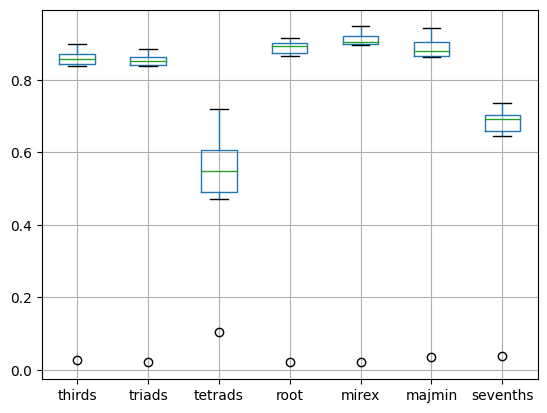

In [142]:
plt.figure()
dfr.boxplot();

### Chordgram

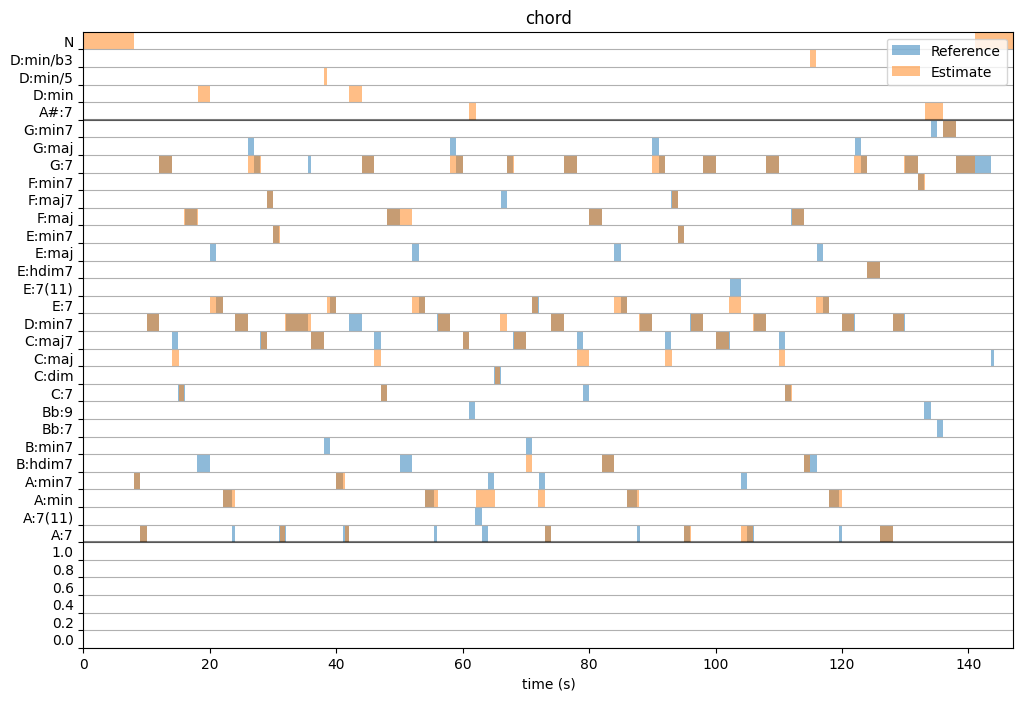

In [143]:
plt.figure(figsize=(12, 8))
jams.display.display(ref_ann, meta=False, label='Reference', alpha=0.5)
jams.display.display(est_ann, meta=False, label='Estimate', alpha=0.5)
plt.xlabel('time (s)')
plt.legend()